# Introduction to Recurrent Neural Networks (RNNs)

Recurrent Neural Networks (RNNs) are a class of neural networks designed for sequential data processing. Unlike traditional feedforward neural networks, RNNs have the ability to capture and utilize information from previous time steps, making them suitable for tasks involving sequential dependencies.

In this notebook, we will explore the fundamental concepts of RNNs using a simple implementation in PyTorch. We will create a custom RNN model, generate synthetic sequential data, and train the model to predict the next point in a sequence based on its previous values.

## Custom RNN Model

We start by defining a custom RNN model named `SimpleRNN`. This model implements a simple RNN using only linear layers and a non-linearity (tanh activation function) to capture sequential dependencies. The model is designed to predict the next point in a sequence.

The parameters needed and the forward pass to be implemented in the `SimpleRNN` model can be described by the following equations:

1. **Update Hidden State:**
   \[ $h_t = \tanh(W_{xh} \cdot x + W_{hh} \cdot h_{\text{prev}} + b)$ \]

   Where:
   - \( $h_t$ \) is the current hidden state.
   - \( $x$ \) is the input.
   - \( $h_{\text{prev}}$ \) is the previous hidden state.
   - \( $W_{xh}$ \) is the weight matrix for the input.
   - \( $W_{hh}$ \) is the weight matrix for the hidden state.
   - \($b$\) is the bias term. Note that if you use Liner layers to implement this model, they already include biases if bias=True is used as an argument of the nn.Linear.

2. **Output Prediction:**
   \[ $y_t = W_{hy} \cdot h_t$ \]

   Where:
   - \( $y_t$ \) is the output prediction.
   - \( $h_t$ \) is the current hidden state.
   - \( $W_{hy}$ \) is the weight matrix for the output.

3. **Initial state $h_0$:**
   The initial state $h_0$ needs to be explicitly creates as a parameter of the network. In the code this is done by defining the variable self.h0, which serves as the initial hidden state for the recurrent neural network (RNN).
   This variables is created as: ```self.h0 = nn.Parameter(torch.rand([1, hidden_size]))```.
   nn.Parameter is a class in PyTorch that is used to define learnable parameters within a PyTorch model. These parameters are automatically registered as model parameters, and their values can be updated during the training process through backpropagation. torch.rand([1, hidden_size]) initializes self.h0 with random values. Using random initialization helps break symmetries in the model and allows the learning process to start with a variety of hidden states.

The forward function returns both the output prediction \( y_t \) and the updated hidden state \( h_t \).




In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define the custom RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()

        self.hidden_size = hidden_size

        self.h0 = nn.Parameter(torch.rand([1, hidden_size]))

        self.Wxh = nn.Linear(input_size, hidden_size)
        self.Whh = nn.Linear(hidden_size, hidden_size)
        self.Why = nn.Linear(hidden_size, output_size)

        # Non-linearity (you can experiment with different activation functions)
        self.tanh = nn.Tanh()

    def forward(self, x, h_prev):
        # Update hidden state using the RNN equations
        h_t = self.tanh(self.Wxh(x) + self.Whh(h_prev))
        
        # Output prediction
        y_t = self.Why(h_t)

        return y_t, h_t



### Generating Synthetic Data
To demonstrate the capabilities of the RNN, we generate synthetic data by combining sine and cosine functions with random weights and frequencies. This synthetic data is then visualized to provide insight into the structure of the sequences.

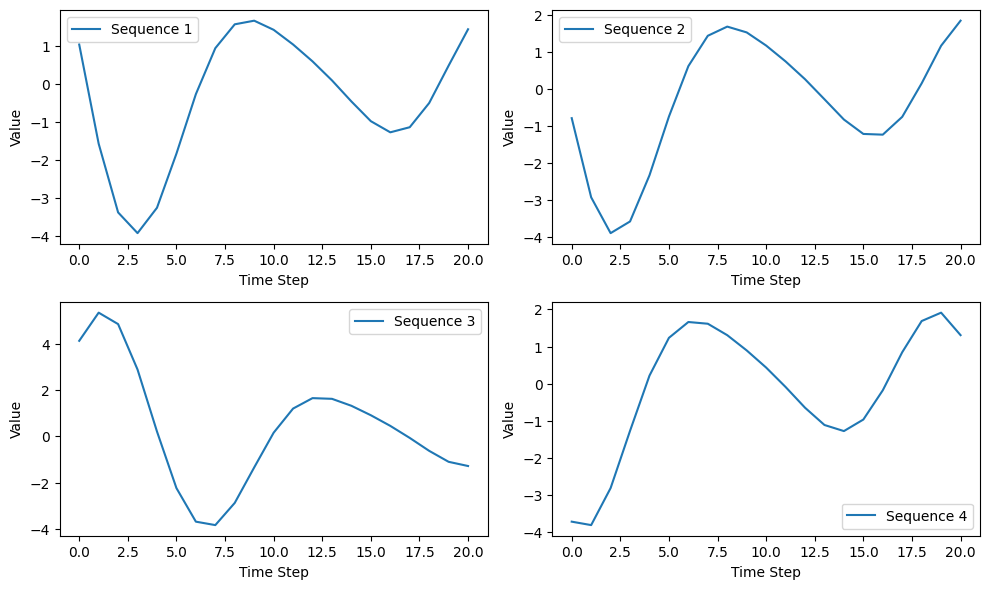

In [18]:
# Generate synthetic data using a combination of sine and cosine functions
def generate_synthetic_data(num_samples, seq_length, frequencies, weights):
    data = []

    for _ in range(num_samples):
        to = np.random.rand(1)*2 
        t = np.linspace(to, to + 2 * np.pi, seq_length+1)
        sequence = np.zeros([seq_length+1, 1])
        for freq, weight in zip(frequencies, weights):
            sequence += weight * np.sin(freq * t) + weight * np.cos(freq * t)
        data.append(sequence)

    return np.array(data)

# Hyperparameters
num_samples = 300
seq_length = 20
input_size = 1
output_size = 1
hidden_size = 8

# Generate synthetic data
np.random.seed(42)
frequencies = np.random.uniform(0.5, 2.5, size=4)
weights = np.random.uniform(0.5, 2.0, size=4)
synthetic_data = generate_synthetic_data(num_samples, seq_length, frequencies, weights)

# Visualize a few sequences from the synthetic data
num_sequences_to_visualize = 5

# Visualize a few sequences from the synthetic data
num_sequences_to_visualize = 4

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i in range(num_sequences_to_visualize):
    row = i // 2
    col = i % 2
    axes[row, col].plot(synthetic_data[i], label=f'Sequence {i + 1}')
    axes[row, col].set_xlabel('Time Step')
    axes[row, col].set_ylabel('Value')
    axes[row, col].legend()

plt.tight_layout()
plt.show()







### Training the RNN
The RNN is trained using the synthetic data. We employ Mean Squared Error (MSE) as the loss function and the Adam optimizer for parameter updates. The training loop iterates through epochs, updating the model parameters to minimize the prediction error.

In [19]:
# Convert the data to PyTorch tensors
X_tensor = torch.FloatTensor(synthetic_data[:, :-1]).unsqueeze(-1)
y_tensor = torch.FloatTensor(synthetic_data[:, -1]).unsqueeze(-1)

# Instantiate the model, loss function, and optimizer
model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10

for epoch in range(epochs):
    total_loss = 0.0

    for i in range(len(X_tensor)):
        # Forward pass
        h_prev = model.h0
        output_seq = []

        for t in range(X_tensor.shape[1]):
            output, h_prev = model(X_tensor[i, t], h_prev)
            output_seq.append(output)

        output = output_seq[-1]

        # Compute the loss
        loss = criterion(output, y_tensor[i])

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print average loss for the epoch
    average_loss = total_loss / len(X_tensor)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.8f}")



Epoch 1/10, Loss: 0.51335406
Epoch 2/10, Loss: 0.04032832
Epoch 3/10, Loss: 0.02251597
Epoch 4/10, Loss: 0.01774637
Epoch 5/10, Loss: 0.01266489
Epoch 6/10, Loss: 0.00767575
Epoch 7/10, Loss: 0.00445714
Epoch 8/10, Loss: 0.00266580
Epoch 9/10, Loss: 0.00167400
Epoch 10/10, Loss: 0.00110617


### Visualizing Predictions
After training, we visualize the RNN's predictions compared to the ground truth for a few sequences. This provides a qualitative assessment of the model's ability to capture the underlying patterns in the data. When interpreting the results note that the prediction gets better the more data the network has seen; so, at the begining the predictions are not so good, but in the last time steps they become much better.

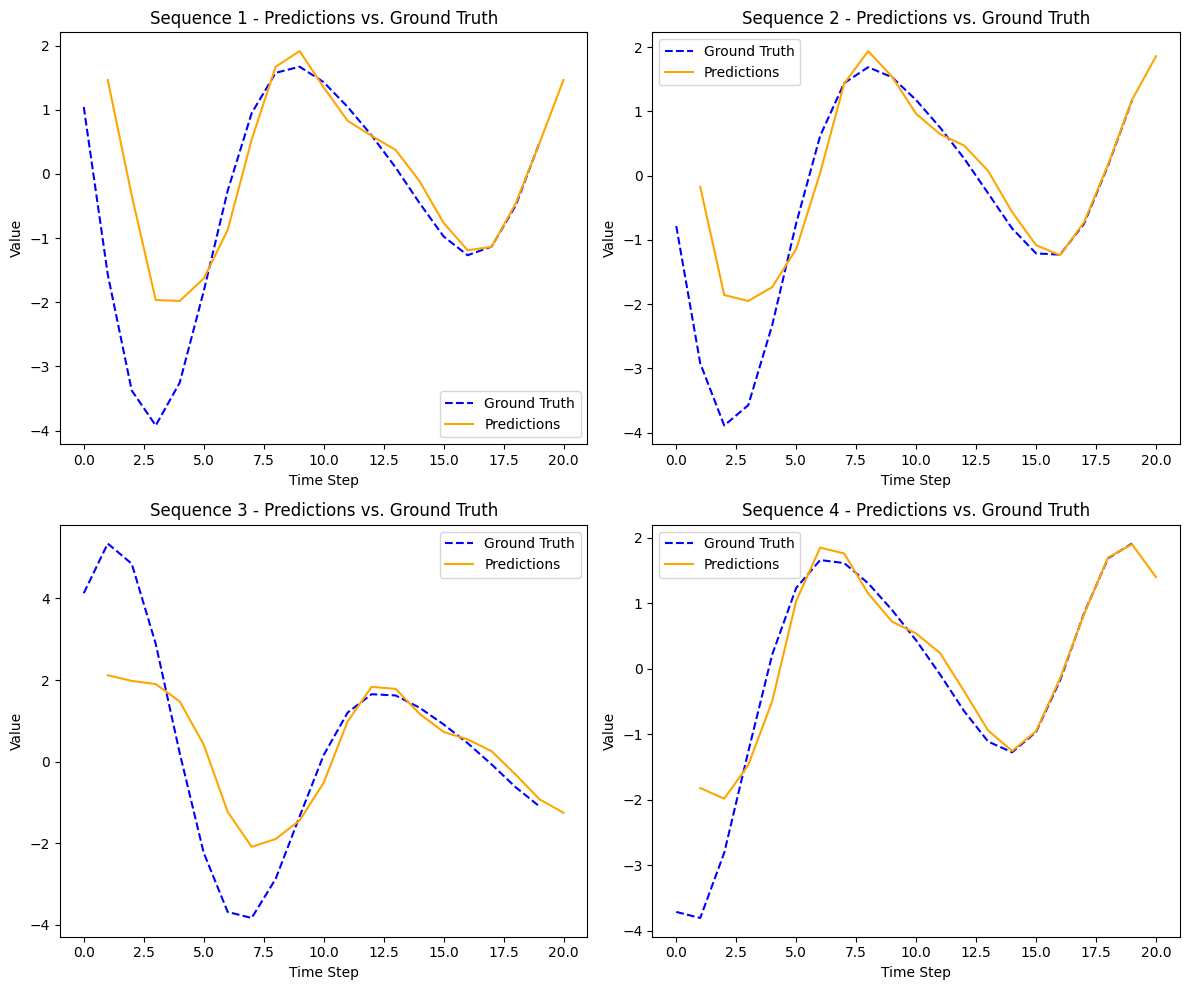

In [20]:
# Visualize predictions
with torch.no_grad():
    model.eval()
    predictions = []

    for i in range(len(X_tensor)):
        h_prev = torch.zeros(1, model.hidden_size)
        prediction_seq = []

        for t in range(X_tensor.shape[1]):
            output, h_prev = model(X_tensor[i, t], h_prev)
            prediction_seq.append(output.item())

        predictions.append(prediction_seq)

# Visualize predictions vs. ground truth in a 2 by 2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i in range(num_sequences_to_visualize):
    row = i // 2
    col = i % 2
    axes[row, col].plot(X_tensor[i].squeeze(), label='Ground Truth', linestyle='--', color='blue')
    axes[row, col].plot(np.arange(1, seq_length+1), predictions[i], label='Predictions', linestyle='-', color='orange')
    axes[row, col].set_xlabel('Time Step')
    axes[row, col].set_ylabel('Value')
    axes[row, col].legend()
    axes[row, col].set_title(f'Sequence {i + 1} - Predictions vs. Ground Truth')

plt.tight_layout()
plt.show()

This notebook serves as an introductory guide to RNNs, illustrating their application in sequence modeling. Feel free to experiment with hyperparameters, explore different activation functions to deepen your understanding of recurrent neural networks.